# Модель сегментации объектов ландшафта на данных АФС

## Содержание
* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Выбор гиперпараметров](#Выбор-гиперпараметров)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Скорость работы](#Скорость-работы)
* [Критика](#Критика)
* [Краткое резюме](#Краткое-резюме)
* [Предложения по улучшению и развитию модели](#Предложения-по-улучшению-и-развитию-модели)

## Постановка задачи

## Датасет

In [2]:
import sys
sys.path.append('../')

from datetime import datetime
from functools import partial

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from srr.batchflow import FilesIndex, Dataset, Pipeline, F, V, B, C, R, P
from srr.batchflow.models.tf import UNet

from srr import AerialBatch
from srr.core.utils import get_origs, ce_dice_loss, make_mask

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
ind = FilesIndex(path='../ignore/deepglobe/train/*.jpg')
ads = Dataset(ind, AerialBatch)
ads.split(0.8, shuffle=False)

In [4]:
# Another representation 
# 0 Unknown
# 1 Water
# 2 Forest land
# 3 Urban land
# 5 Rangeland
# 6 Agriculture land
# 7 Barren land

make_mask = partial(make_mask, classes=(1,2))

Определение функции потерь:

In [ ]:
ce_dice_loss = partial(ce_dice_loss, alpha=0.75)

## Архитектура

Используется модель UNet, реализованная в библиотеке ```batchflow.models.tf```.

Общее описание архитектуры модели доступно по ссылке [https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html)

Выбранная конфигурация модели:
############# TBD ##################### 

Задание конфигурации модели:

In [5]:
model_config = {
    'initial_block/inputs': 'images',
    'inputs': dict(images={'shape': (256,256,3)}, 
                   masks={'name':'targets',
                          'shape': (256,256,3)}),
    'filters': [64, 128, 256, 512],
    'head/num_classes': 3,
    'loss': ce_dice_loss,
    'optimizer': 'Adam',
    'output': ['proba', 'class']
}

## Обучение

Обучение проиcходит итерациями по батчам. Итерации состоит из:
* генерации очередной порции данных
* обновления весов нейронной сети.

Для обучения выбран оптимизатор Adam со стандартными параметрами:
* ```learning_rate``` = 0.001
* ```beta1``` = 0.9
* ```beta2``` = 0.999
* ```epsilon``` = 1e-08.

Функция потерь - cross-entropy.

Схема обхода датасета:

In [6]:
batch_size = 8
n_epochs = 600

Размер кропов:

In [ ]:
crop_shape = (256, 256)

Описание пайплайна обучения:

In [7]:
train_template = (
      Pipeline()
      .load(ind, fmt='image', dst='images')
      .load(ind, fmt='mask', dst='masks')
      .resize(size=(1224, 1224), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(get_origs, crop_shape, 1., src='masks', dst='origs')
      .crop(shape=crop_shape, src=[('images', 'origs'), ('masks', 'origs')], dst=['images', 'masks'])
      .rotate(P(R('randint', 0, 180)), src=['images', 'masks'], dst=['images', 'masks'], p=0.5)
      .flip('lr', src=['images', 'masks'], dst=['images', 'masks'], p=0.5)
      .enhance(factor=P(R('uniform', 0.5, 1.5)))
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, src='masks', dst='masks')
      .init_variable('loss', init_on_each_run=list)
      .init_model('dynamic', UNet, 'unet', model_config)
      .train_model('unet', images=B('images'), targets=B('masks'),
                      fetches='loss', save_to=V('loss'), mode='a')
).run(batch_size, shuffle=True, lazy=True)

Запуск обучения:

In [8]:
train_pipeline = (train_template << ads.train)

In [ ]:
train_pipeline.run(batch_size, n_epochs=n_epochs, bar=True, drop_last=True)

 61%|██████▏   | 29511/48000 [14:05:58<8:30:22,  1.66s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 69%|██████▉   | 33191/48000 [15:51:27<6:54:33,  1.68s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73%|███████▎  | 34909/48000 [16:40:37<6:12:20,  1.71s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable

График функции потерь в зависимости от числа итераций:

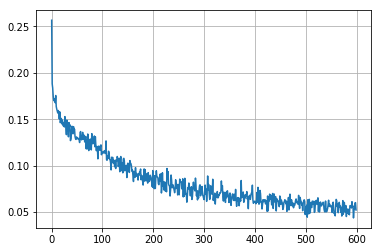

In [12]:
l = np.split(np.array(train_pipeline.get_variable('loss')), n_epochs)
plt.plot(np.array(l).mean(-1))
plt.grid(True)

In [13]:
MODEL_PATH = '../ignore/models/' + datetime.now().strftime(format='%Y%m%d%H%M')
train_pipeline.save_model('unet', path=MODEL_PATH)

## Оценка модели

Качество модели определяется средним значением метрики IOU (intersection over union) по выборке из 1000 картинок.

Описание процедуры расчета метрики:

In [9]:
MODEL_PATH = '../ignore/models/201904071718/'

In [10]:
load_model_config = {
    'build': False,
    'load': {'path': MODEL_PATH}
}

In [11]:
test_template = (
      Pipeline()
      .load(ind, fmt='image', dst='images')
      .load(ind, fmt='mask', dst='masks')
      .resize(size=(1224, 1224), src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(get_origs, crop_shape, 1., src='masks', dst='origs')
      .crop(shape=crop_shape, src=[('images', 'origs'), ('masks', 'origs')], dst=['images', 'masks'])
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, src='masks', dst='masks')
      .init_variable('batch_predictions', init_on_each_run=list)
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('metrics', init_on_each_run=None)
      .init_variable('images', init_on_each_run=list)
      .init_variable('masks', init_on_each_run=list)
      .init_model('static', UNet, 'unet', config=load_model_config)
#       .import_model('unet', train_pipeline)
      .predict_model('unet', images=B('images'), targets=B('masks'),
                   fetches=['proba'], save_to=[V('batch_predictions')], mode='w')
      .gather_metrics('segmentation', axis=-1, targets=B('masks'), predictions=V('batch_predictions'),
                      fmt='proba', save_to=V('metrics'), mode='u')
      .update_variable('images', B('images'), mode='e')
      .update_variable('masks', B('masks'), mode='e')
      .update_variable('predictions', V('batch_predictions'), mode='e')
).run(batch_size, n_epochs=1, lazy=True)

INFO:tensorflow:Restoring parameters from ../ignore/models/201904071718/model-48000


Запуск расчета метрики

In [12]:
test_pipeline = ((test_template << ads.test).run(batch_size, shuffle=False, 
                                                 n_epochs=1, drop_last=False, bar=True))

 95%|█████████▌| 20/21 [00:28<00:01,  1.31s/it]


In [13]:
metrics = test_pipeline.get_variable('metrics')
print("IOU: %.3f" % metrics.evaluate('iou', agg='mean'))
print("Confusion matrix:\n {}".format(metrics._confusion_matrix.sum(axis=0)))

IOU: 0.826
Confusion matrix:
 [[8568266   96500  200991]
 [  48882  209243    1385]
 [ 210235    9785 1206009]]


Пример исходного изображения и предсказанной сегментации

In [14]:
y_pred = test_pipeline.get_variable('predictions')
images = test_pipeline.get_variable('images')
masks = test_pipeline.get_variable('masks')

Text(0.5, 1.0, 'Forest')

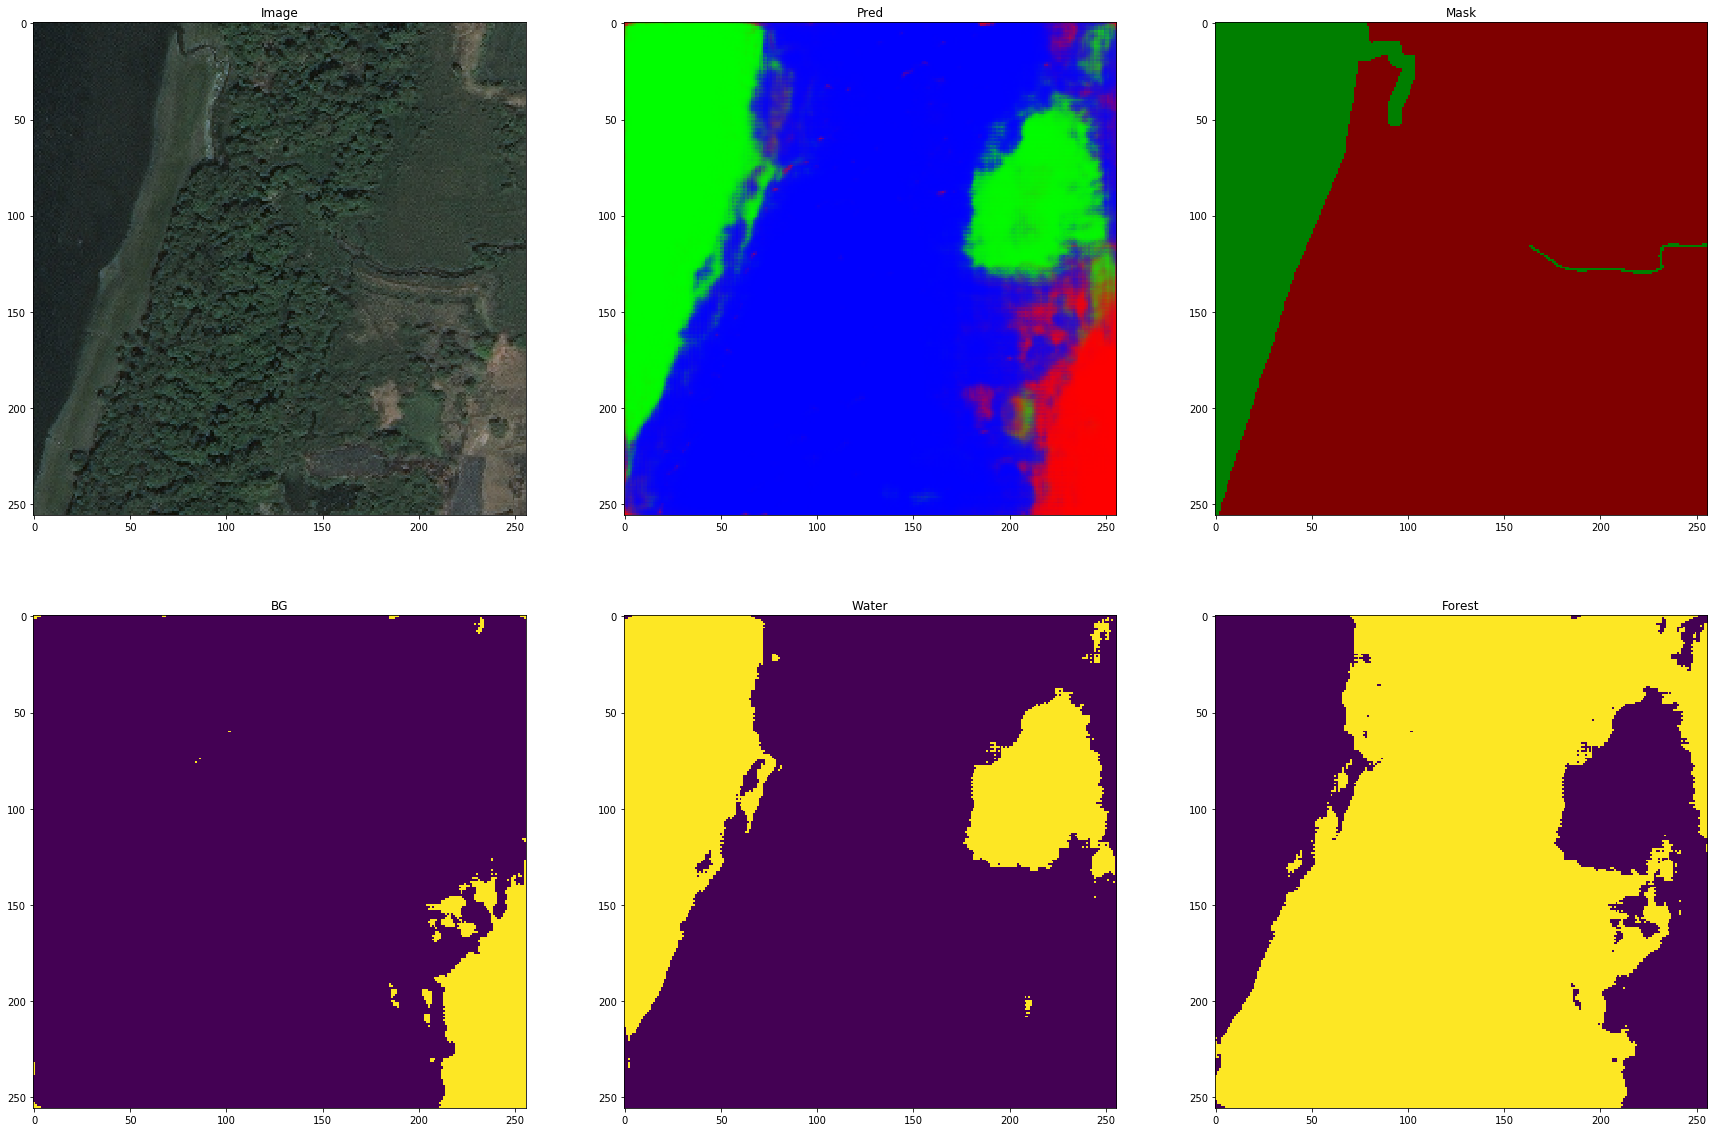

In [20]:
i = np.random.randint(len(masks))

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 20))
ax1.imshow(images[i])
ax1.set_title('Image')
ax2.imshow(y_pred[i])
ax2.set_title('Pred')
ax3.imshow(masks[i]*127)
ax3.set_title('Mask')
ax4.imshow(y_pred[i][:,:,0]>0.5)
ax4.set_title('BG')
ax5.imshow(y_pred[i][:,:,1]>0.5)
ax5.set_title('Water')
ax6.imshow(y_pred[i][:,:,2]>0.5)
ax6.set_title('Forest')

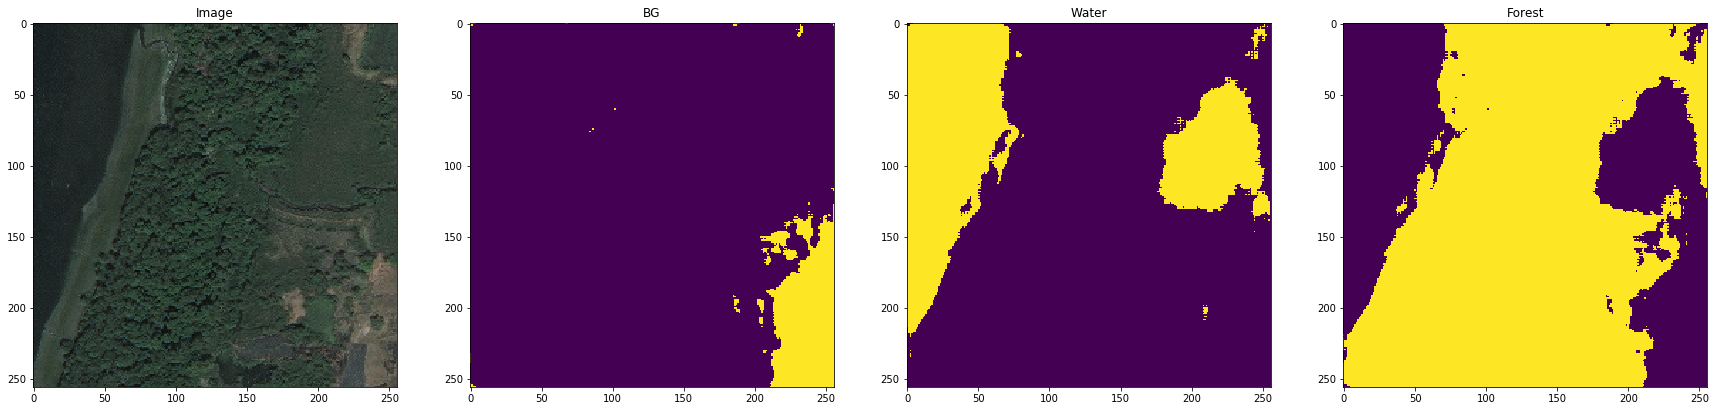

In [21]:
f, ((ax1, ax4, ax5, ax6)) = plt.subplots(1, 4, figsize=(30, 20))
ax1.imshow(images[i])
ax1.set_title('Image')
ax4.imshow(y_pred[i][:,:,0]>0.5)
ax4.set_title('BG')
ax5.imshow(y_pred[i][:,:,1]>0.5)
ax5.set_title('Water')
ax6.imshow(y_pred[i][:,:,2]>0.5)
ax6.set_title('Forest')
plt.savefig(MODEL_PATH.split('/')[-1]+'_aerial_sample_{}.png'.format(i))